In [1]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as implt
from scipy.spatial.distance import cdist
from PIL import Image, ImageEnhance

In [2]:
shape=(128,128)

Load data

In [3]:
def load_and_preprocess_image(image_path):
    """Load an image and apply Gaussian blur."""
    image = implt.imread(image_path)
    image = cv2.resize(image,shape)
    # image=image/255.0
    return image

RGB to RGBY

In [31]:
def convert_rgb_to_rgby(images):
    rgby=[]
    for i in range(len(images)):
        # Separate the RGB channels
        r, g, b = cv2.split(images[i])

        # Create the yellow channel as an average of red and green channels
        y = cv2.addWeighted(r, 0.5, g, 0.5,0)

        g=cv2.addWeighted(g,0.5)
        r=cv2.addWeighted(r,0.5)

        # Combine the RGB channels with the new Y channel to form an RGBy image
        image=cv2.merge((r, g , b , y))
        rgby.append(image)
    rgby=np.array(rgby)

    return rgby

Optimal K value

In [4]:
def find_optimal_k(image, threshold=200*255*255, max_k=50, step=5):
    data = np.float32(image).reshape((-1, 3))
    for k in range(1, max_k + 1, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia = kmeans.inertia_
        # print(f"k={k}, Inertia={inertia}")
        if inertia < threshold:
            # print(f"optimal k is :{k}")
            return k
    return k

Quatize color using k value

In [5]:
def color_quantization(image, k=None):
    """Reduce the number of colors using k-means clustering."""
    if k is None:
        k = find_optimal_k(image)
    data = np.float32(image).reshape((-1, 4))
    data=data
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.75)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape(image.shape)
    segmented_image=segmented_image
    # plt.imshow(segmented_image)
    return segmented_image

image preprocessing

In [11]:
def increase_saturation(image, saturation_factor=1.5):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Convert to float32 to prevent clipping issues during multiplication
    hsv_image = hsv_image.astype('float32')

    # Increase saturation by the specified factor
    hsv_image[:, :, 1] *= saturation_factor

    # Clip the values to stay within valid range [0, 255] and convert back to uint8
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)
    hsv_image = hsv_image.astype('uint8')

    # Convert back to BGR color space
    output_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return output_image

In [7]:
def increase_contrast(image, output_path=None, factor=2.0):
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    enhancer = ImageEnhance.Contrast(img)

    # Apply the contrast enhancement
    img_enhanced = enhancer.enhance(factor)

    return np.array(img_enhanced)

Implementation

In [13]:
image_path='./image'
sketch_path='./sketch'

In [14]:
images=np.array([load_and_preprocess_image(os.path.join(image_path,i)) for i in os.listdir(image_path)])
sketches=np.array([load_and_preprocess_image(os.path.join(sketch_path,i)) for i in os.listdir(sketch_path)])
sketch_binary_mask=[]
aplhas=[]

In [15]:
for sketch in sketches:
    r, g, b, a = cv2.split(sketch)
    # Threshold the alpha channel to create a binary mask
    _, binary_mask = cv2.threshold(a, 0, 1, cv2.THRESH_BINARY)
    sketch_binary_mask.append(binary_mask)
    # plt.imshow(binary_mask,cmap='binary')
    # plt.show()

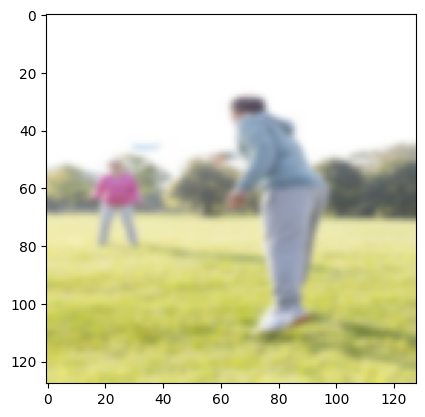

In [16]:
blurred_images=[cv2.GaussianBlur(i,(5,5),0) for i in images]
plt.imshow(blurred_images[0])


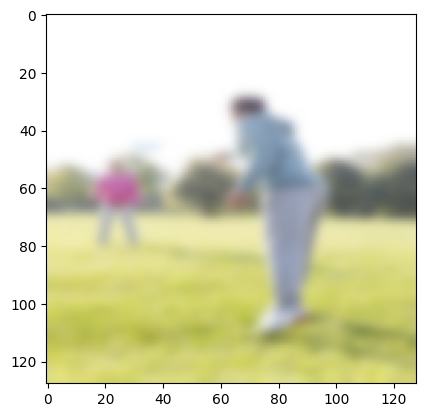

In [17]:
high_blur=blurred_images
for _ in range(2):
    high_blur=[cv2.GaussianBlur(i,(5,5),0) for i in high_blur]
plt.imshow(high_blur[0])


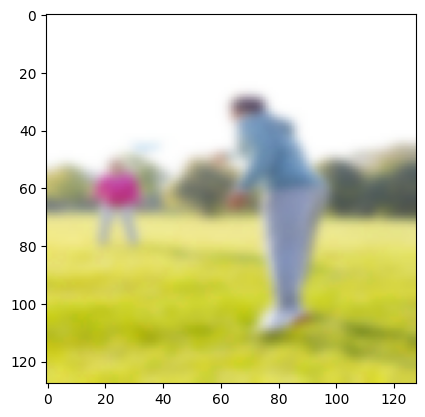

In [18]:
high_blur=[increase_saturation(i) for i in high_blur]
plt.imshow(high_blur[0])

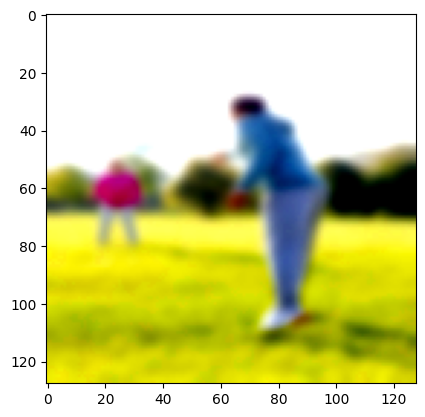

In [19]:
high_blur=[increase_contrast(i) for i in high_blur]
plt.imshow(high_blur[0])

In [30]:
quatized_image=high_blur.copy()
quatized_image=convert_rgb_to_rgby(quatized_image)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'addWeighted'
> Overload resolution failed:
>  - addWeighted() missing required argument 'src2' (pos 3)
>  - addWeighted() missing required argument 'src2' (pos 3)


In [107]:
for i in range(len(quatized_image)):
    quatized_image[i]=color_quantization(high_blur[i])


In [106]:
# cv2.imwrite(f'./quatized_images/{os.listdir(image_path)[0]}', quatized_image[0])

True

In [114]:
for i in range(len(quatized_image)):
    cv2.imwrite(f'./quatized2/{os.listdir(image_path)[i]}', quatized_image[i])


In [115]:
def overlap_both(quatized_image,sketch_binary_mask):
    # Create an empty result image
    result_image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    # Loop through each pixel in the images
    for y in range(256):
        for x in range(256):
            # Check if the corresponding pixel in the binary mask is dark
            if sketch_binary_mask[y][x] == 0:
                # If dark, copy the pixel from the normal image to the result image
                result_image[y][x] = quatized_image[y][x]
    # plt.imshow(result_image)
    # plt.show()

In [116]:
for i in range(5):
    overlap_both(quatized_image[i],sketch_binary_mask[i])

IndexError: list index out of range

In [ ]:
def color_outline(quatized_image,sketch_binary_mask):
    # Create an empty result image
    result_image = np.ones((shape[0], shape[1], 3), dtype=np.uint8)*255

    # Loop through each pixel in the images
    for y in range(256):
        for x in range(256):
            # Check if the corresponding pixel in the binary mask is dark
            if sketch_binary_mask[y][x] != 0:
                # If dark, copy the pixel from the normal image to the result image
                result_image[y][x] = quatized_image[y][x]
    # plt.imshow(result_image)
    # plt.show()

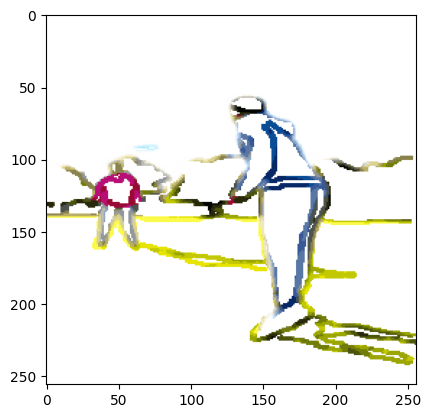

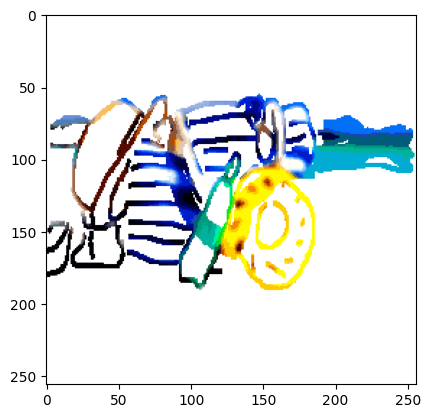

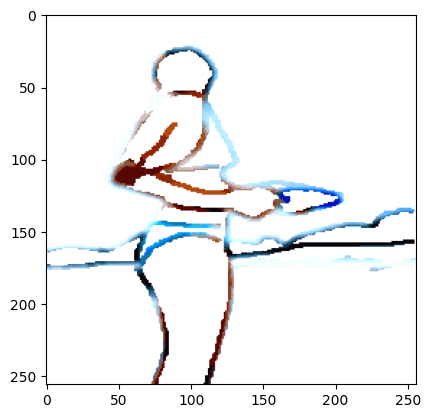

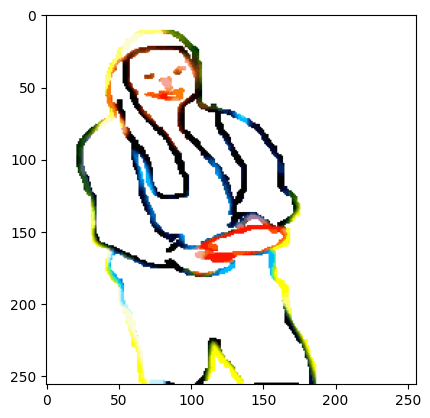

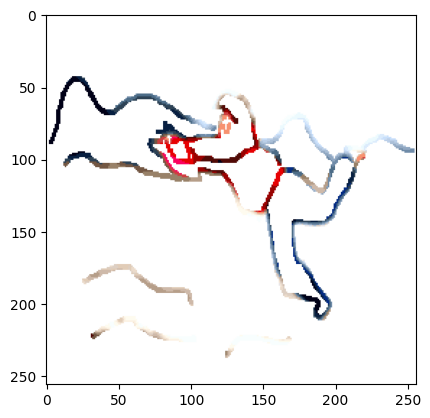

In [ ]:
for i in range(5):
    color_outline(quatized_image[i],sketch_binary_mask[i])